In [1]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [8]:
# Clearing the environment

try:
    del full_dataset, train_indices, val_indices, train_subset, val_subset, train_loader, val_loader, labels, class_names, model, criterion, optimizer
except NameError:
    print("Some are non-existent!")

!rm -rf /kaggle/working/*
%reset -f


import gc

def reset_memory():
    # Delete all variables.
    for var in gc.get_objects():
        try:
            del var
        except:
            pass

    # Run the garbage collector.
    gc.collect()

    print("Memory has been reset")

# Call the function to reset memory

reset_memory()

Memory has been reset


In [4]:
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
import timm
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Preparing the dataframe of file paths and labels

data_dir = ('/kaggle/input/gtsrb-german-traffic-sign/Train/')

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Valid image extensions
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

max_per_class = 500
class_counts = defaultdict(int)

# Walk through all subfolders and files
for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(valid_extensions):
            full_path = os.path.join(subdir, file)
            label = os.path.basename(subdir)

            if class_counts[label] < max_per_class:
                file_paths.append(full_path)
                labels.append(label)
                class_counts[label] += 1
                
# Create a DataFrame
data_df = pd.DataFrame({'file_path': file_paths, 'label': labels})
data_df = data_df.sort_values(by='label', ascending=True)

# Display the DataFrame
print(data_df.head())
print(data_df.label.value_counts())

                                              file_path label
8215  /kaggle/input/gtsrb-german-traffic-sign/Train/...     0
8185  /kaggle/input/gtsrb-german-traffic-sign/Train/...     0
8184  /kaggle/input/gtsrb-german-traffic-sign/Train/...     0
8183  /kaggle/input/gtsrb-german-traffic-sign/Train/...     0
8182  /kaggle/input/gtsrb-german-traffic-sign/Train/...     0
label
1     500
10    500
11    500
15    500
12    500
13    500
14    500
18    500
17    500
23    500
2     500
5     500
9     500
25    500
26    500
3     500
31    500
28    500
33    500
38    500
4     500
8     500
7     500
35    500
30    450
6     420
16    420
34    420
36    390
22    390
20    360
40    360
21    330
39    300
24    270
29    270
41    240
27    240
32    240
42    240
0     210
19    210
37    210
Name: count, dtype: int64


In [5]:
# convert labels to integers

label_map = {label: idx for idx, label in enumerate(data_df['label'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}
data_df['label'] = data_df['label'].map(label_map)
print(data_df.head())
print(data_df.tail())

                                              file_path  label
8215  /kaggle/input/gtsrb-german-traffic-sign/Train/...      0
8185  /kaggle/input/gtsrb-german-traffic-sign/Train/...      0
8184  /kaggle/input/gtsrb-german-traffic-sign/Train/...      0
8183  /kaggle/input/gtsrb-german-traffic-sign/Train/...      0
8182  /kaggle/input/gtsrb-german-traffic-sign/Train/...      0
                                               file_path  label
14769  /kaggle/input/gtsrb-german-traffic-sign/Train/...     42
14768  /kaggle/input/gtsrb-german-traffic-sign/Train/...     42
14767  /kaggle/input/gtsrb-german-traffic-sign/Train/...     42
14780  /kaggle/input/gtsrb-german-traffic-sign/Train/...     42
14930  /kaggle/input/gtsrb-german-traffic-sign/Train/...     42


In [6]:
# Defining the dataset creator

from torch.utils.data import Dataset
from PIL import Image

class TrafficSignDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['file_path']
        image = Image.open(image_path).convert('RGB')
        
        label = self.dataframe.iloc[idx]['label']

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [7]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)), # all requires 224px, except maxvit, mobilevitv2, darknet53, and edgenext, requiring 256px, inceptionv3, xception, and inceptionresnetv2, requiring 299px
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load full dataset
full_dataset = TrafficSignDataset(dataframe=data_df, transform=transform)

# Optional: extract labels and class names
labels = [label for _, label in full_dataset]

class_names = []

for idx in data_df['label'].unique():
    class_names.append(inverse_label_map[idx])

train_indices, val_indices = train_test_split(np.arange(len(full_dataset)),test_size=0.2,stratify=labels,random_state=42)

train_subset = Subset(full_dataset, train_indices)
val_subset = Subset(full_dataset, val_indices)

# Dataloaders
train_loader = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False, num_workers=4)

# Load pretrained Swin Transformer
import timm
model = timm.create_model('pvt_v2_b0', pretrained=True, num_classes=len(class_names))
model = model.to(device)

# mobilenetv3_small_100, resnet50/101, efficientnet_b0, inception_resnet_v2 (299), densenet121, inception_v3, xception41/65/71, regnety_032, darknet53, cspdarknet53, rexnet_200, edgenext_small, convnextv2_nano
# tiny_vit_5m_224, swin_tiny_patch4_window7_224, maxvit_nano_rw_256, coatnet_nano_rw_224, davit_tiny, resnetv2_50/101x1_bit, pvt_v2_b0/b1, mobilevitv2_200, convformer/caformer_s18, twins_svt/pcpvt_small, mvitv2_tiny, visformer_tiny/small, 

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.safetensors:   0%|          | 0.00/14.7M [00:00<?, ?B/s]

In [8]:
# For tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_acc = 0.0
best_model_path = 'best_model.pth'

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}]"
          f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%"
          f"  || Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved new best model with val_acc: {val_acc:.2f}%")

Epoch [1/10]  Train Loss: 0.2721 | Train Acc: 92.75%  || Val Loss: 0.0397 | Val Acc: 98.61%
Saved new best model with val_acc: 98.61%
Epoch [2/10]  Train Loss: 0.0421 | Train Acc: 98.90%  || Val Loss: 0.0136 | Val Acc: 99.72%
Saved new best model with val_acc: 99.72%
Epoch [3/10]  Train Loss: 0.0248 | Train Acc: 99.35%  || Val Loss: 0.0133 | Val Acc: 99.58%
Epoch [4/10]  Train Loss: 0.0289 | Train Acc: 99.26%  || Val Loss: 0.0041 | Val Acc: 99.94%
Saved new best model with val_acc: 99.94%
Epoch [5/10]  Train Loss: 0.0132 | Train Acc: 99.65%  || Val Loss: 0.0254 | Val Acc: 99.36%
Epoch [6/10]  Train Loss: 0.0207 | Train Acc: 99.43%  || Val Loss: 0.0172 | Val Acc: 99.53%
Epoch [7/10]  Train Loss: 0.0140 | Train Acc: 99.59%  || Val Loss: 0.0429 | Val Acc: 99.00%
Epoch [8/10]  Train Loss: 0.0172 | Train Acc: 99.57%  || Val Loss: 0.0151 | Val Acc: 99.58%
Epoch [9/10]  Train Loss: 0.0133 | Train Acc: 99.70%  || Val Loss: 0.0168 | Val Acc: 99.53%
Epoch [10/10]  Train Loss: 0.0121 | Train Acc:

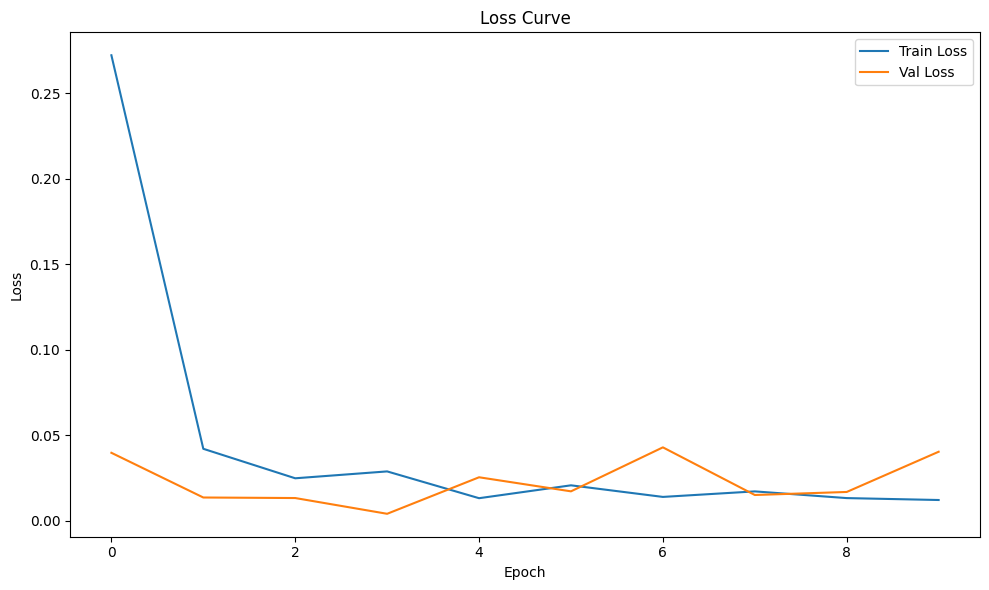

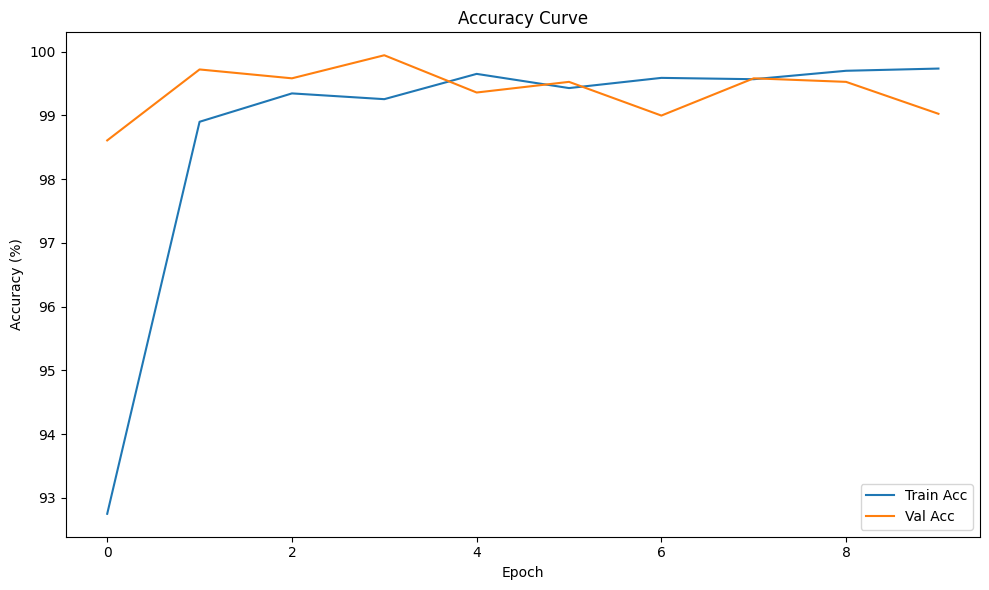

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Plot Loss and Accuracy
plt.figure(figsize=(10, 6))

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.savefig('Loss.png', dpi=1200)
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.savefig('Acc.png', dpi=1200)
plt.legend()

plt.tight_layout()
plt.show()

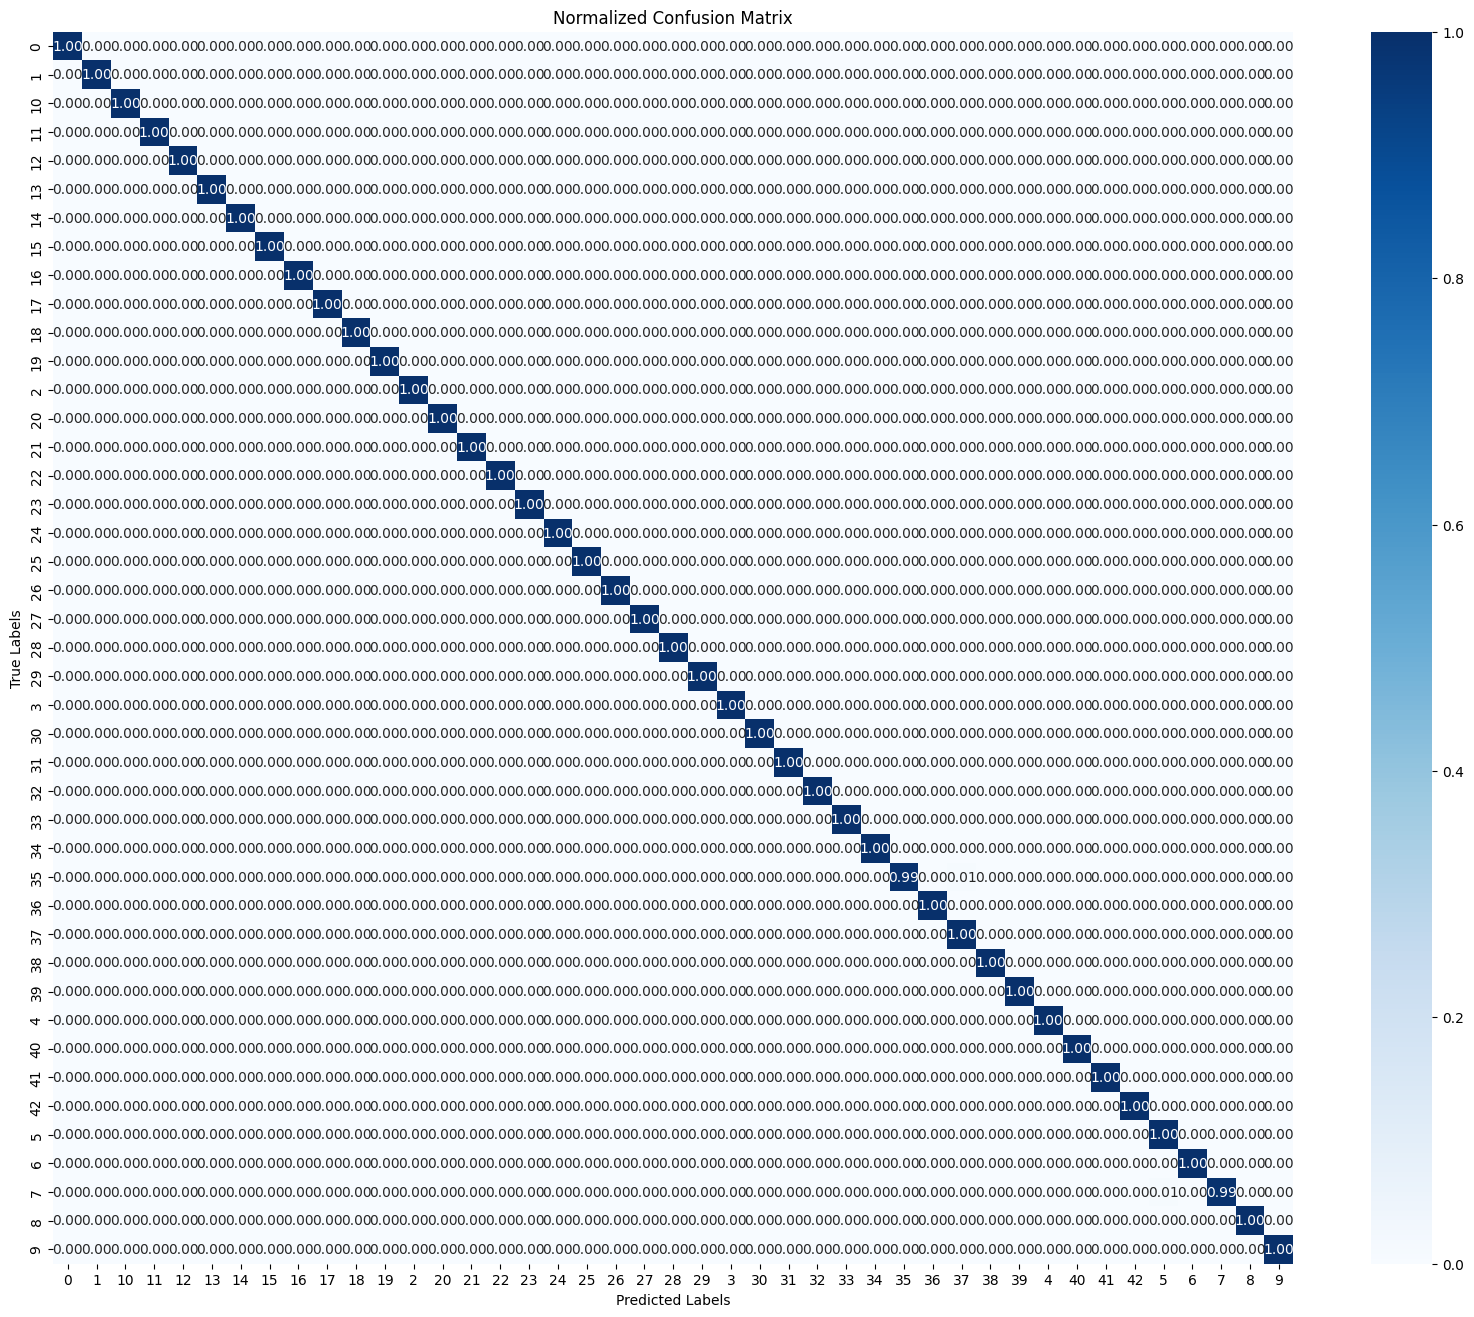

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00       100
          10       1.00      1.00      1.00       100
          11       1.00      1.00      1.00       100
          12       1.00      1.00      1.00       100
          13       1.00      1.00      1.00       100
          14       1.00      1.00      1.00       100
          15       1.00      1.00      1.00       100
          16       1.00      1.00      1.00        84
          17       1.00      1.00      1.00       100
          18       1.00      1.00      1.00       100
          19       1.00      1.00      1.00        42
           2       1.00      1.00      1.00       100
          20       1.00      1.00      1.00        72
          21       1.00      1.00      1.00        66
          22       1.00      1.00      1.00        78
          23       1.00      1.00      1.00       100
    

In [10]:
class_names = []

for idx in data_df['label'].unique():
    class_names.append(inverse_label_map[idx])

# Confusion Matrix
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(20, 16))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.savefig('Conf_Mat.png', dpi=1200)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
print("\nConfusion Matrix:\n")
print(confusion_matrix(all_labels, all_preds))